# Greenhouse gas benefit from salvage logging
### British Columbia's Forest Carbon Initiative

Robbie Hember (Robert.Hember@gov.bc.ca)

Climate Change and Integrated Planning Branch

BC Ministry of Forests, Lands, Natural Resource Operations and Rural Development

## 1. Introduction

### 1.1. Description

This project demonstrates the GHG benefit associated from salvage logging stands impacted by Mountain Pine Beetle. That is, instead of just underplanting, the project salvages the dead and remaining live trees and then re-plants. 

To achieve this, the user can use the Clearcut and Salvage Logging disturbance matrix developed by the CFS, or they can set custom assumptions. The demo runs through the use of custom assumptions to represent the salvage project.

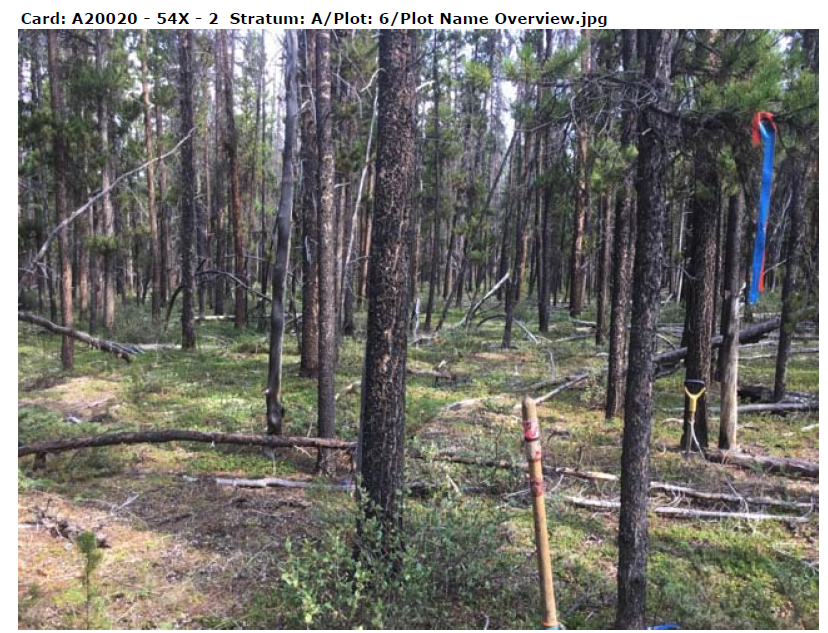

In [17]:
from IPython.display import Image
Image(r'Z:\!Workgrp\Forest Carbon\Pictures - move to BO 306\201808_AnahimLakeRegenSurveys\AnahimLakeRegenSurveys.png')

## 2. Methods

### 2.1. Project log

Version 2018-09-20; By Robbie; CBRunner.py R2018d; BatchTIPSY.exe 4.4; Note 1 - None.

Version 2019-02-07; By Robbie; CBRunner.py R2018f; BatchTIPSY.exe 4.4; Note 1 - Added change management system. Improved format. I decided to change the Mortality 50 to Mortality 75 disturbance. It appears to have minimal effect on GHG benefit.

Version 2019-11-01; By Robbie; CBRunner.py R2019c; BatchTIPSY.exe 4.4; Note 1 - Update to model version, update to script, cleaning, no changes to results.

Version 2019-12-10; By Robbie; CBRunner.py R2019d; BatchTIPSY.exe 4.4; Note 1 - Update to model version, update to script, cleaning, no changes to results.

Version 2020-03-1; By Robbie; fcgadgets.cbrunner.py; BatchTIPSY.exe 4.4; Note 1 - Code maintenance, no changes to results.

### 2.2. Prepare session

In [1]:
# Import Python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from fcgadgets.pyscripts import utilities_general as gu
from fcgadgets.pyscripts import utilities_gis as gis
from fcgadgets.cbrunner.cbrun_utilities import *
from fcgadgets.cbrunner.cbrun import *

In [2]:
# Prepare notebook settings

# Force inline plotting
%matplotlib inline
plt.style.use('ggplot')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Change cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; } .output {align-items: center; }</style>"))

In [3]:
# Configure project
meta={}
meta['Path Project']=r'G:\My Drive\Data\FCI_Demo_ReforestationSalvageLoggingMPB'
meta['Path Model Code']=r'G:\My Drive\Code_Python\fcgadgets\cbrunner'
meta=ImportProjectConfig(meta)

### 2.3. Prepare yield curves

1) Manually define the gorwth curves that you want to run in TIPSY by parameterizing the Growth Curve Parameters spreadsheet.

In [4]:
# 2) Automatically create the formatted input file for BatchTIPSY.exe based on how the "Define Growth Curves" spreadsheet was parameterized:
BuildTIPSYInputs(meta)

3) Manually run TIPSY after making sure the input file is up-to-date. This should create the .out ascii file.

### 2.4. Prepare inventory

In [4]:
# Loop through batches, saving inventory to file
for iScn in range(0,meta['N Scenario']):
    
    # Loop through batches, saving inventory to file
    for iBat in range(0,meta['N Batch']):
      
        inv={}
    
        # Index to batch
        iStart=meta['Batch Interval']*iBat
        iStop=np.minimum(meta['N Stand'],iStart+meta['Batch Interval'])
        indBat=np.arange(iStart,iStop,1)    
        N_StandsInBatch=len(indBat)
    
        # Initialize inventory variables
        inv['Lat']=np.zeros((1,N_StandsInBatch))
        inv['Lon']=np.zeros((1,N_StandsInBatch))
        inv['X']=inv['Lat']
        inv['Y']=inv['Lon']
        
        # BEC zone
        inv['ID_BECZ']=meta['LUT BGC Zone']['IDF']*np.ones((1,N_StandsInBatch),dtype=np.int)                  
    
        # Temperature will be updated automatically
        inv['MAT']=4*np.ones((1,N_StandsInBatch))
    
        if meta['Biomass Module']=='Sawtooth':
            inv['Srs1_ID']=meta['LUT Spc'][meta['Scenario'][iScn]['SRS1_CD']]*np.ones((1,N_StandsInBatch),dtype=np.int)
        else:
            inv['Srs1_ID']=9999*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs1_Pct']=100*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs2_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs2_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs3_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Srs3_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc1_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc1_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc2_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc2_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc3_ID']=0*np.ones((1,N_StandsInBatch),dtype=np.int)
        inv['Spc3_Pct']=0*np.ones((1,N_StandsInBatch),dtype=np.int)

        # Save
        gu.opickle(meta['Path Input Scenario'][iScn] + '\\Inventory_Bat' + FixFileNum(iBat) + '.pkl',inv)        

### 2.5. Prepare disturbance history

In [6]:
for iScn in range(meta['N Scenario']):    
    for iEns in range(meta['N Ensemble']):        
        for iBat in range(meta['N Batch']):
    
            # Index to batch
            iStart=meta['Batch Interval']*iBat
            iStop=np.minimum(meta['N Stand'],iStart+meta['Batch Interval'])
            indBat=np.arange(iStart,iStop,1)
            N_StandsInBatch=len(indBat)
    
            # Build disturbance history for each stand
            eh=list()
            for iStandBat in range(N_StandsInBatch):
            
                eh0={}
        
                # Spinup disturbances
                eh0=CompileDisturbancesForSpinup(meta,iScn,eh0)
                
                # Simulated historical disturbances
                eh0=CompileHistoricalDisturbancesFromSimulation(meta,iScn,eh0)
                
                # Disturbance from inventory
                eh0=CompileDisturbancesFromInventory(meta,iScn,eh0) 

                # Simulated future disturbances
                eh0=CompileFutureDisturbancesFromSimulation(meta,iScn,eh0)
            
                # Initialize custom disturbance variables
                for k in range(len(meta['Name CustDistVar'])):
                    eh0[meta['Name CustDistVar'][k]]=np.zeros(eh0['Year'].size,dtype=np.int16)
        
                # Populate custom ecosystem to product transfer assumptions
                iCustomHarvest=np.where(eh0['ID_Type']==meta['LUT Dist']['Harvest Custom'])[0]
                for k in range(len(meta['Name CustDistVar'])):
                    if iScn+1==2:
                        # Slashpile burning
                        etpt=ImportCustomHarvestAssumptions(meta['Path Project'] + '\\Inputs\\CustomHarvest_1.xlsx')
                        eh0[meta['Name CustDistVar'][k]][iCustomHarvest]=etpt[meta['Name CustDistVar'][k]]
                    elif iScn+1==3:
                        # Low fibre utilization
                        etpt=ImportCustomHarvestAssumptions(meta['Path Project'] + '\\Inputs\\CustomHarvest_2.xlsx')                        
                        eh0[meta['Name CustDistVar'][k]][iCustomHarvest]=etpt[meta['Name CustDistVar'][k]]
                    elif iScn+1==4:
                        # High fibre utilization
                        etpt=ImportCustomHarvestAssumptions(meta['Path Project'] + '\\Inputs\\CustomHarvest_3.xlsx')                        
                        eh0[meta['Name CustDistVar'][k]][iCustomHarvest]=etpt[meta['Name CustDistVar'][k]]
                    
                # Add to Events structure
                eh.append(eh0)

            # Save to file            
            gu.opickle(meta['Path Input Scenario'][iScn] + '\\Disturbance_Ens' + FixFileNum(iEns) + '_Bat' + FixFileNum(iBat) + '.pkl',eh)

### 2.6. Prepare growth curves

In [7]:
# Compile growth curves
PostProcessTIPSY(meta)

### 2.7. Run simulation

In [7]:
# Excecute CBRunner.py
RunProject(meta);

Running Scenario 0001, Ensemble 0001, Batch 0001
1.4723525047302246
Running Scenario 0002, Ensemble 0001, Batch 0001
1.3339600563049316
Running Scenario 0003, Ensemble 0001, Batch 0001
1.3211710453033447
Running Scenario 0004, Ensemble 0001, Batch 0001
1.2750568389892578


## 3. Results

### 3.1. Import data

In [8]:
# Open results 
v1,meta=LoadScenarioResults(meta)

# Convert pools and fluxes to CO2e
v2,meta=CalculateGHGBalance(v1,meta)

# Disturbance history
dh=GetDisturbanceHistory(meta)  

# Import time series of areas disturbed for each scenario
A=GetAreasAffected(meta)

In [9]:
# Set figure properties
params={'font.sans-serif':'Arial',
        'font.size':14,
        'axes.edgecolor':'black',
        'axes.labelsize':14,
        'axes.labelcolor':'black',
        'axes.titlesize':12,
        'axes.linewidth':0.5,        
        'lines.linewidth':2,
        'text.color':'black',
        'xtick.color':'black',        
        'xtick.labelsize':12,
        'xtick.major.width':0.5,
        'xtick.major.size':3,
        'xtick.direction':'in',
        'ytick.color':'black',
        'ytick.labelsize':12,
        'ytick.major.width':0.5,
        'ytick.major.size':3,
        'ytick.direction':'in',
        'legend.fontsize':14,        
        'savefig.dpi':200,
        'savefig.transparent':True,
        'savefig.format':'png'}
plt.rcParams.update(params)

In [10]:
# Plot disturbance and management history

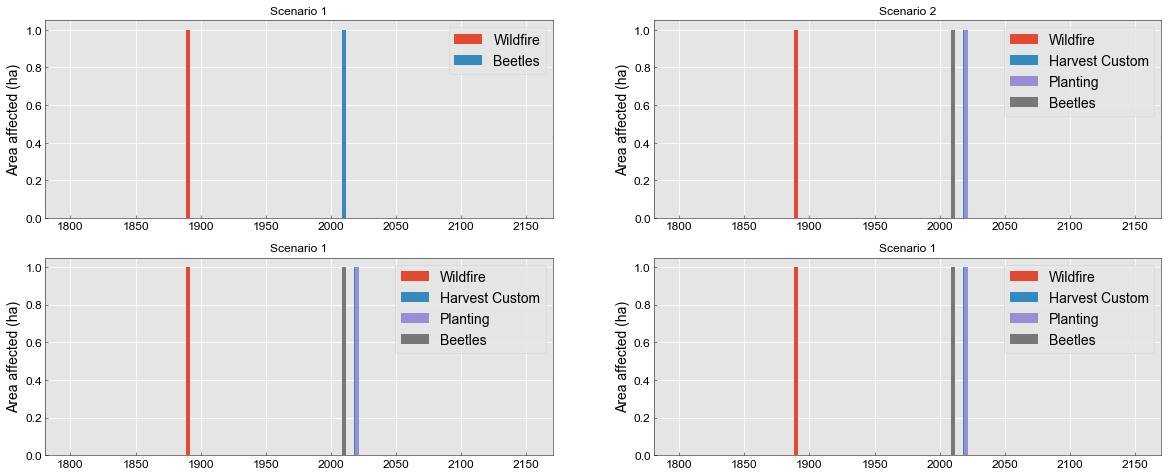

In [24]:
it=np.where(v1[0].Year>=1800)[0]
bw=3
fig,ax=plt.subplots(2,2,figsize=(20,8))
for key in A[0].keys(): 
    if np.sum(A[0][key][it])==0: continue
    if key=='Harvest (all)': continue
    ax[0,0].bar(v1[0].Year[it],A[0][key][it],bw,label=key)
ax[0,0].legend()
ax[0,0].set(title='Scenario 1',ylabel='Area affected (ha)');
for key in A[1].keys(): 
    if np.sum(A[1][key][it])==0: continue
    if key=='Harvest (all)': continue
    ax[0,1].bar(v1[0].Year[it],A[1][key][it],bw,label=key)
ax[0,1].legend()
ax[0,1].set(title='Scenario 2',ylabel='Area affected (ha)');
for key in A[2].keys(): 
    if np.sum(A[2][key][it])==0: continue
    if key=='Harvest (all)': continue
    ax[1,0].bar(v1[2].Year[it],A[2][key][it],bw,label=key)
ax[1,0].legend()
ax[1,0].set(title='Scenario 1',ylabel='Area affected (ha)');
for key in A[3].keys(): 
    if np.sum(A[3][key][it])==0: continue
    if key=='Harvest (all)': continue
    ax[1,1].bar(v1[3].Year[it],A[3][key][it],bw,label=key)
ax[1,1].legend()
ax[1,1].set(title='Scenario 1',ylabel='Area affected (ha)');

### 3.2. Impacts on carbon pools

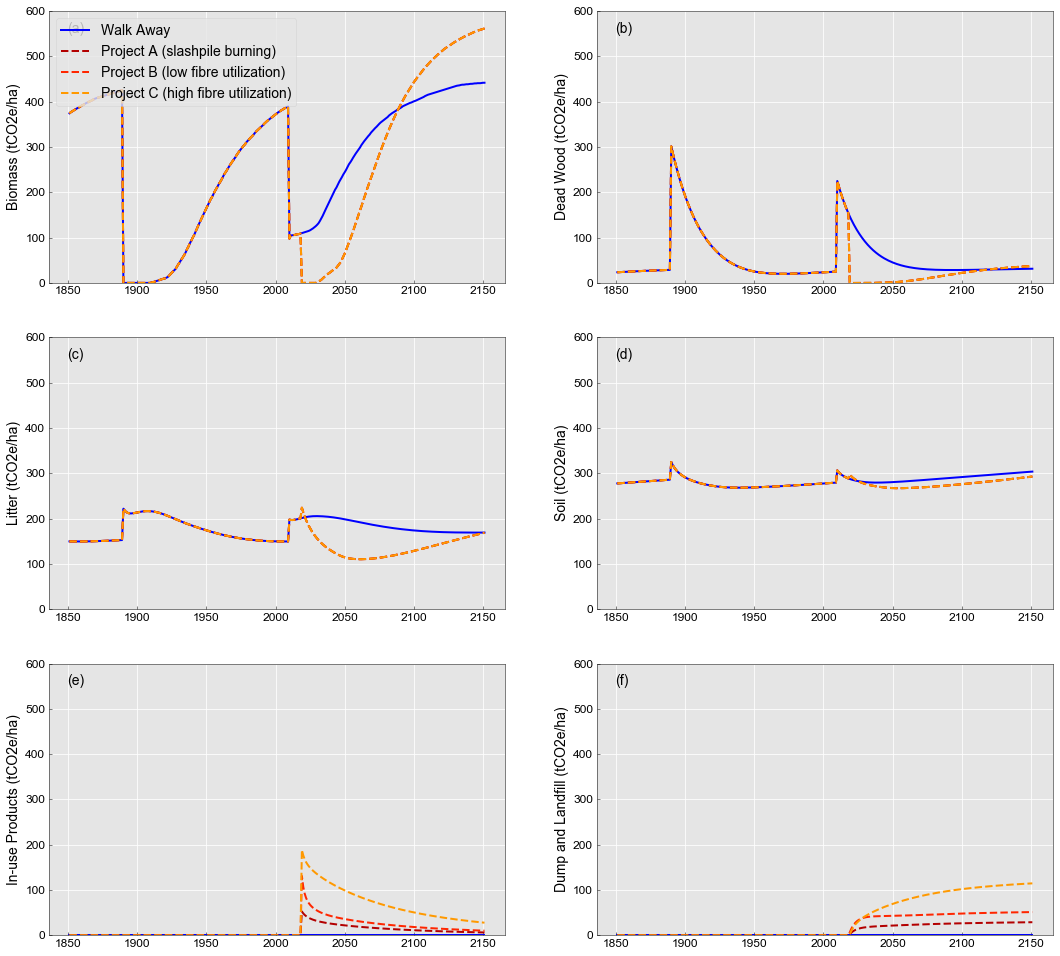

In [17]:
# Plot ecosystem and product sector pools
vs=['Eco_Biomass','Eco_DeadWood','Eco_Litter','Eco_Soil','Pro_InUse','Pro_DumpLandfill']
vs2=['Biomass','Dead Wood','Litter','Soil','In-use Products','Dump and Landfill']
scn=['Walk Away','Project A (slashpile burning)','Project B (low fibre utilization)','Project C (high fibre utilization)']
tlab=['(a)','(b)','(c)','(d)','(e)','(f)']
cl=np.array([[0,0,1],[0.7,0,0],[1,0.15,0],[1,0.6,0]])
it=np.where(v1[0].Year>1850)[0]
cnt=0
fig,ax=plt.subplots(3,2,figsize=(18,17))
for i in range(3):
    for j in range(2):
        for k in range(4):
            exec('tmp=v2[k].' + str(vs[cnt]))
            if k==0:
                ls='-'
            else:
                ls='--'                    
            ax[i,j].plot(v1[0].Year[it],tmp[it],ls,color=cl[k,:],label=scn[k])        
        ax[i,j].set(ylabel=vs2[cnt] + ' (tCO2e/ha)')
        ax[i,j].set_ylim(bottom=0,top=600);
        if (i==0) & (j==0):
            ax[i,j].legend(loc="upper left")
        cnt=cnt+1
#ax[0,0].set_ylim(bottom=0,top=800);
gu.axletters(ax,plt,0.04,0.92);

### 3.2. Impacts on carbon fluxes

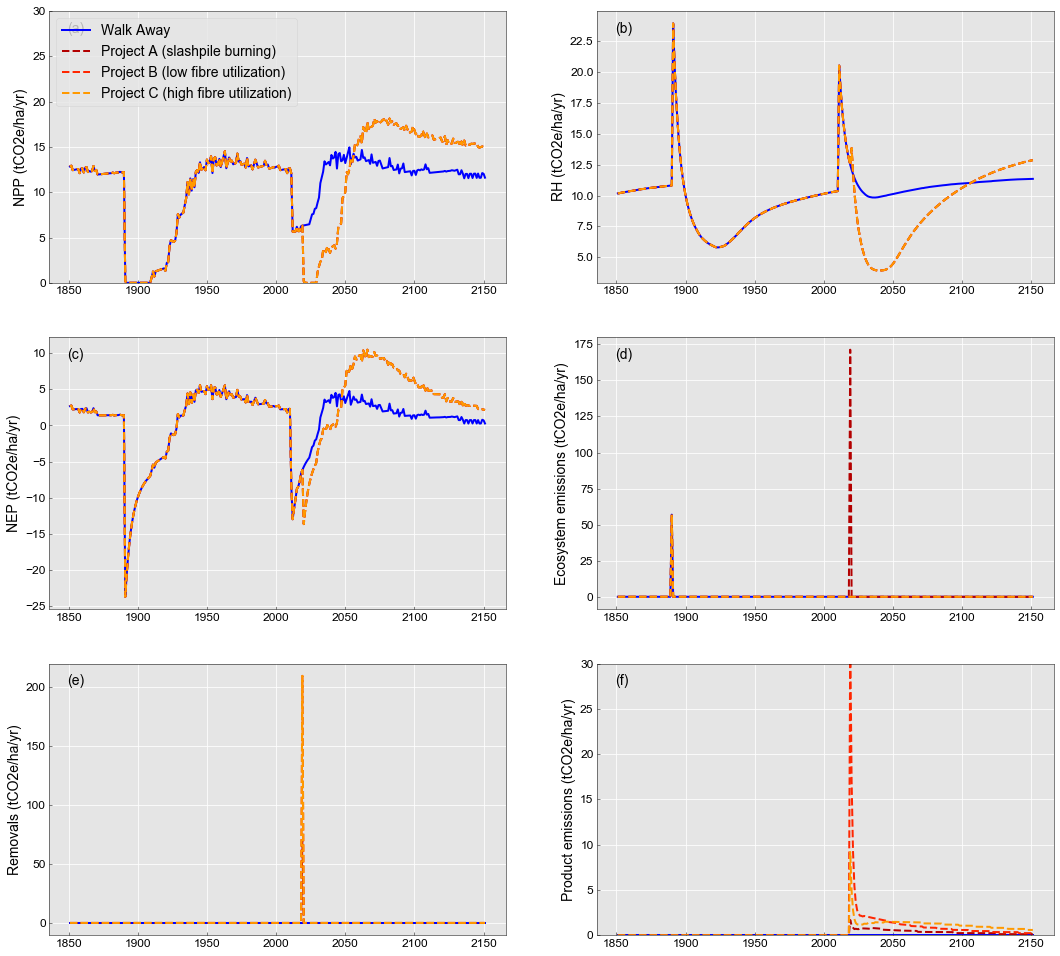

In [18]:
# Plot ecosystem and product sector pools

for i in range(4):
    v2[i].Eco_NEP=v2[i].Eco_NPP-v2[i].Eco_RH

vs=['Eco_NPP','Eco_RH','Eco_NEP','Eco_E_Fire','Eco_Removals','Pro_Emissions']
vs2=['NPP','RH','NEP','Ecosystem emissions','Removals','Product emissions']
scn=['Walk Away','Project A (slashpile burning)','Project B (low fibre utilization)','Project C (high fibre utilization)']
tlab=['(a)','(b)','(c)','(d)','(e)','(f)']
cl=np.array([[0,0,1],[0.7,0,0],[1,0.15,0],[1,0.6,0]])
it=np.where(v1[0].Year>1850)[0]
cnt=0
fig,ax=plt.subplots(3,2,figsize=(18,17))
for i in range(3):
    for j in range(2):
        for k in range(4):
            exec('tmp=v2[k].' + str(vs[cnt]))
            if k==0:
                ls='-'
            else:
                ls='--'                    
            ax[i,j].plot(v1[0].Year[it],tmp[it],ls,color=cl[k,:],label=scn[k])        
        ax[i,j].set(ylabel=vs2[cnt] + ' (tCO2e/ha/yr)')
        if (i==0) & (j==0):
            ax[i,j].legend(loc="upper left")
        cnt=cnt+1
ax[0,0].set_ylim(bottom=0,top=30)
ax[2,1].set_ylim(bottom=0,top=30)
gu.axletters(ax,plt,0.04,0.92);

### 3.3. Impacts on net sector carbon balance and GHG benefit

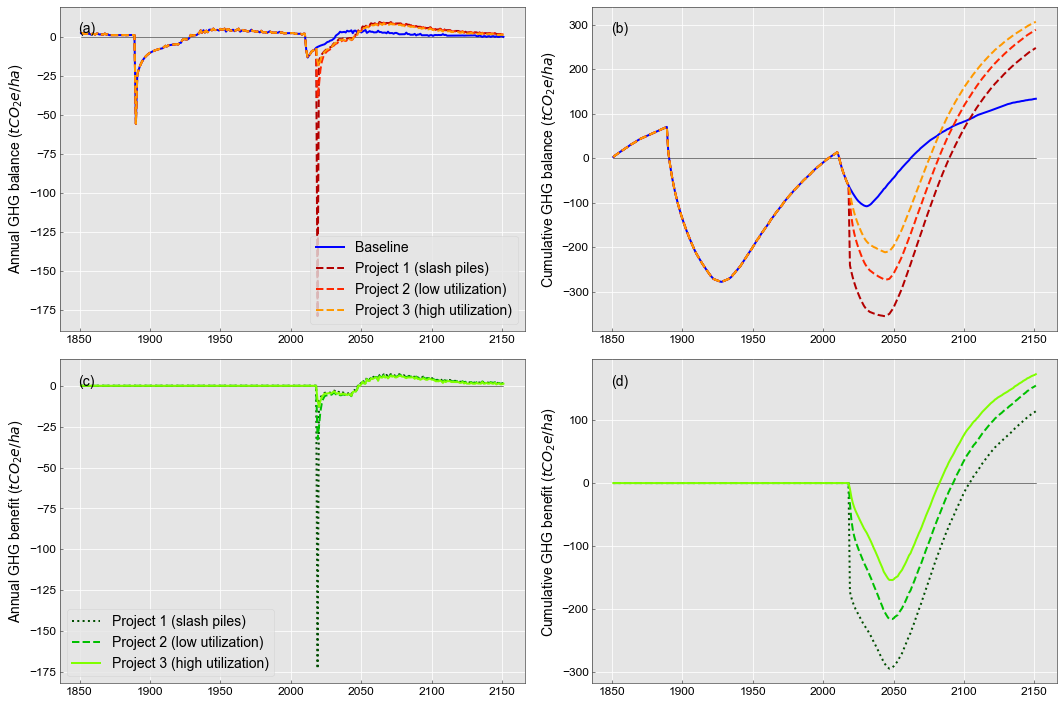

In [19]:
it=np.where(v1[0].Year>1850)[0]

fig,ax=plt.subplots(2,2,figsize=(15, 10))
labs1=['Annual GHG balance','Cumulative GHG balance','Annual GHG benefit','Cumulative GHG benefit']
ax[0,0].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].size),'-',linewidth=0.5,color=(0,0,0))
ax[0,0].plot(v2[0].Year[it],v2[0].Sec_NGHGB[it],'-',color=(0,0,1),label='Baseline')
ax[0,0].plot(v2[0].Year[it],v2[1].Sec_NGHGB[it],'--',color=(0.7,0,0),label='Project 1 (slash piles)')
ax[0,0].plot(v2[0].Year[it],v2[2].Sec_NGHGB[it],'--',color=(1,0.15,0),label='Project 2 (low utilization)')
ax[0,0].plot(v2[0].Year[it],v2[3].Sec_NGHGB[it],'--',color=(1,0.6,0),label='Project 3 (high utilization)')
ax[0,0].legend(loc="lower right")
ax[0,1].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].size),'-',linewidth=0.5,color=(0,0,0))
ax[0,1].plot(v2[0].Year[it],np.cumsum(v2[0].Sec_NGHGB[it]),'-',color=(0,0,1),label='Baseline')
ax[0,1].plot(v2[0].Year[it],np.cumsum(v2[1].Sec_NGHGB[it]),'--',color=(0.7,0,0),label='Project 1 (slash piles)')
ax[0,1].plot(v2[0].Year[it],np.cumsum(v2[2].Sec_NGHGB[it]),'--',color=(1,0.15,0),label='Project 2 (low utilization)')
ax[0,1].plot(v2[0].Year[it],np.cumsum(v2[3].Sec_NGHGB[it]),'--',color=(1,0.6,0),label='Project 3 (high utilization)')
ax[1,0].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].size),'-',linewidth=0.5,color=(0,0,0))
ax[1,0].plot(v2[0].Year[it],v2[1].Sec_NGHGB[it]-v2[0].Sec_NGHGB[it],':',color=(0,0.3,0),label='Project 1 (slash piles)')
ax[1,0].plot(v2[0].Year[it],v2[2].Sec_NGHGB[it]-v2[0].Sec_NGHGB[it],'--',color=(0,0.75,0),label='Project 2 (low utilization)')
ax[1,0].plot(v2[0].Year[it],v2[3].Sec_NGHGB[it]-v2[0].Sec_NGHGB[it],'-',color=(0.5,1,0),label='Project 3 (high utilization)')
ax[1,0].legend(loc="lower left")
ax[1,1].plot(v2[0].Year[it],0*np.ones(v2[0].Year[it].size),'-',linewidth=0.5,color=(0,0,0))
ax[1,1].plot(v2[0].Year[it],np.cumsum(v2[1].Sec_NGHGB[it])-np.cumsum(v2[0].Sec_NGHGB[it]),':',color=(0,0.3,0),label='Delta cumulative NECB')
ax[1,1].plot(v2[0].Year[it],np.cumsum(v2[2].Sec_NGHGB[it])-np.cumsum(v2[0].Sec_NGHGB[it]),'--',color=(0,0.75,0),label='Delta cumulative NECB')
ax[1,1].plot(v2[0].Year[it],np.cumsum(v2[3].Sec_NGHGB[it])-np.cumsum(v2[0].Sec_NGHGB[it]),'-',color=(0.5,1,0),label='Delta cumulative NECB')
gu.axletters(ax,plt,0.04,0.92)
cnt=0
for i in range(2):
    for j in range(2):
        ax[i,j].set(ylabel=labs1[cnt] + ' ($tCO_2e/ha$)')
        cnt=cnt+1
plt.tight_layout();

In [20]:
# Tabulate results in a summary table
df=pd.DataFrame(columns=['Variable','Value'])

df['Variable']=['Annual GHG benefit 2030 (tCO2e/ha/yr)','Cumulative GHG benefit 2030 (tCO2e/ha)','Annual GHG benefit 2050 (tCO2e/ha/yr)',
                'Cumulative GHG benefit 2050 (tCO2e/ha)','Annual GHG benefit 2080 (tCO2e/ha/yr)','Cumulative GHG benefit 2080 (tCO2e/ha)']

dA=v2[1].Sec_NGHGB[:,0]-v2[0].Sec_NGHGB[:,0]
dC=np.cumsum(v2[1].Sec_NGHGB[:,0])-np.cumsum(v2[0].Sec_NGHGB[:,0])

it=np.where(v2[0].Year==2030)[0]
dA30=dA[it][0]
dC30=dC[it][0]

it=np.where(v2[0].Year==2050)[0]
dA50=dA[it][0]
dC50=dC[it][0]

it=np.where(v2[0].Year==2080)[0]
dA80=dA[it][0]
dC80=dC[it][0]

df['Value'].iloc[0]=np.round(dA30,decimals=1)
df['Value'].iloc[1]=np.round(dC30,decimals=1)
df['Value'].iloc[2]=np.round(dA50,decimals=1)
df['Value'].iloc[3]=np.round(dC50,decimals=1)
df['Value'].iloc[4]=np.round(dA80,decimals=1)
df['Value'].iloc[5]=np.round(dC80,decimals=1)
df

,Variable,Value
0,Annual GHG benefit 2030 (tCO2e/ha/yr),-3.2
1,Cumulative GHG benefit 2030 (tCO2e/ha),-228.9
2,Annual GHG benefit 2050 (tCO2e/ha/yr),1.9
3,Cumulative GHG benefit 2050 (tCO2e/ha),-291.3
4,Annual GHG benefit 2080 (tCO2e/ha/yr),6.6
5,Cumulative GHG benefit 2080 (tCO2e/ha),-122.3


## Export for FCI database

In [17]:
flg=0
if flg==1:
    df=pd.DataFrame(columns=['Time','Slash Piles','Low Utilization','High Utilization'])
    it=np.where(v2[0].Year>=1990)[0]
    df['Time']=v2[0].Year[it]
    df['Slash Piles']=np.round(v2[1].Sec_NGHGB[it,0]-v2[0].Sec_NGHGB[it,0],2)
    df['Low Utilization']=np.round(v2[2].Sec_NGHGB[it,0]-v2[0].Sec_NGHGB[it,0],2)
    df['High Utilization']=np.round(v2[3].Sec_NGHGB[it,0]-v2[0].Sec_NGHGB[it,0],2)
    df.to_excel(meta['Path Project'] + '\\Outputs\\AnnualGHGBenefitSummary.xlsx',index=False)
    
    # GHG balance for Info Note
    df=pd.DataFrame(columns=['Time','Walk away','Project A (slash piles)','Project B (low utilization)','Project C (high utilization)'])
    it=np.where(v2[0].Year>=1990)[0]
    df['Time']=v2[0].Year[it]
    df['Walk away']=np.round(v2[0].Sec_NGHGB[it,0],2)
    df['Project A (slash piles)']=np.round(v2[1].Sec_NGHGB[it,0],2)
    df['Project B (low utilization)']=np.round(v2[2].Sec_NGHGB[it,0],2)
    df['Project C (high utilization)']=np.round(v2[3].Sec_NGHGB[it,0],2)
    df.to_excel(meta['Path Project'] + '\\Outputs\\AnnualGHGBalance.xlsx',index=False)
    
    # Total sector C
    df=pd.DataFrame(columns=['Time','Walk away','Project A (slash piles)','Project B (low utilization)','Project C (high utilization)'])
    it=np.where(v2[0].Year>=1990)[0]
    df['Time']=v2[0].Year[it]
    df['Walk away']=np.round(np.sum(v[0].C_Eco_Pools[it,0,:],axis=1)+np.sum(v[0].C_Pro_Pools[it,0,:],axis=1),2)
    df['Project A (slash piles)']=np.round(np.sum(v[1].C_Eco_Pools[it,0,:],axis=1)+np.sum(v[1].C_Pro_Pools[it,0,:],axis=1),2)
    df['Project B (low utilization)']=np.round(np.sum(v[2].C_Eco_Pools[it,0,:],axis=1)+np.sum(v[2].C_Pro_Pools[it,0,:],axis=1),2)
    df['Project C (high utilization)']=np.round(np.sum(v[3].C_Eco_Pools[it,0,:],axis=1)+np.sum(v[3].C_Pro_Pools[it,0,:],axis=1),2)
    df.to_excel(meta['Path Project'] + '\\Outputs\\AnnualTotalSectorCarbon.xlsx',index=False)

## Acknowlegements
This work was supported by Canada's Low Carbon Economy Leadership Fund (https://www.canada.ca/en/environment-climate-change/services/climate-change/low-carbon-economy-fund.html).